# CPSC 330 - Applied Machine Learning 

## Homework 3: Preprocessing 
### Associated lectures: [Lectures 4, 5, 6](https://github.com/UBC-CS/cpsc330-2023s/tree/main/lectures) 

**Due date: Monday, Feb 5, 11:59pm. See the [HW schedule](https://github.com/UBC-CS/cpsc330-2023W2#deliverable-due-dates-tentative)**. 


## Imports 

In [1]:
from hashlib import sha1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Instructions
<hr>

_Points: 6_

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W2/blob/master/docs/homework_instructions.md), and the summary at the end of this HW.

**You <u>may</u> work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- You can also work on your own if you prefer.
- The maximum group size is 2.
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This homework will give you some practice of data preprocessing and building a supervised machine learning pipeline on a real-world dataset. 

<br><br>

## Exercise 1: Introducing the dataset
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` under the data folder in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` under the data folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [2]:
census_df = pd.read_csv("data/adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 

_Points: 2_

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (40%) and `test_df` (60%) with `random_state = 123`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.  

_Usually having more data for training is a good idea. But here I'm using 40%/60% split because running cross-validation with this dataset can take a while on a modest laptop. A smaller training data means it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the model performance!_

<div class="alert alert-warning">

Solution_1.1
    
</div>

In [3]:
train_df, test_df = train_test_split(census_df, test_size=0.6, random_state=123)

<br><br>

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [31]:
train_df.sort_index()

train_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5917,26,Private,214303,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,<=50K
32065,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,14,United-States,<=50K
28237,27,Private,202206,11th,7,Separated,Farming-fishing,Other-relative,White,Male,0,0,40,Puerto-Rico,<=50K
12846,49,Private,151584,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
25706,19,Private,351802,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,35,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values because they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [5]:
train_df = train_df.replace("?", np.nan)
test_df = test_df.replace("?", np.nan)
train_df.shape

(13024, 15)

In [6]:
train_df.sort_index()

train_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5917,26,Private,214303,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,<=50K
32065,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,14,United-States,<=50K
28237,27,Private,202206,11th,7,Separated,Farming-fishing,Other-relative,White,Male,0,0,40,Puerto-Rico,<=50K
12846,49,Private,151584,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
25706,19,Private,351802,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,35,United-States,<=50K


The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 `describe()` method

_Points: 5_

**Your tasks:**

1. Examine the output of `train_df.describe()` with `include='all'` argument and store it in a variable called `census_summary`.
2. What is the highest hours per week someone reported? Store it in a variable called `max_hours_per_week`.
3. What is the most frequently occurring occupation in this dataset? Store it in a variable called `most_freq_occupation`.
4. Store the column names of the columns with missing values as a list in a variable called `missing_vals_cols`. 
5. Store the column names of all numeric-looking columns as a list in a variable called `numeric_cols`.  

<div class="alert alert-warning">

Solution_2.1
    
</div>

In [7]:
census_summary = train_df.describe(include='all')

census_summary

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,13024.000000,12284,1.302400e+04,13024,13024.000000,13024,12281,13024,13024,13024,13024.000000,13024.000000,13024.000000,12783,13024
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,40,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,9123,NaN,4153,NaN,5936,1649,5195,11158,8700,NaN,NaN,NaN,11717,9875
mean,38.546913,NaN,1.884759e+05,NaN,10.057432,NaN,NaN,NaN,NaN,NaN,1079.831695,86.543074,40.395654,NaN,NaN
std,13.610225,NaN,1.040895e+05,NaN,2.553084,NaN,NaN,NaN,NaN,NaN,7322.034546,403.025863,12.285347,NaN,NaN
min,17.000000,NaN,1.376900e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.170962e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.778990e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.365655e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [8]:
max_hours_per_week = census_summary.loc['max', 'hours.per.week']

print("Max hours per week: ", max_hours_per_week)

Max hours per week:  99.0


In [9]:
most_freq_occupation = census_summary.loc['top', 'occupation']

print ("Most frequent occupation: ", most_freq_occupation)

Most frequent occupation:  Prof-specialty


In [11]:
missing_vals_cols = train_df.columns[train_df.isnull().any()].tolist()
print('Columns with missing values: ', missing_vals_cols)

print(' ')

numeric_cols = train_df.select_dtypes(include='number').columns.values
print('Numeric columns: ', numeric_cols)


Columns with missing values:  ['workclass', 'occupation', 'native.country']
 
Numeric columns:  ['age' 'fnlwgt' 'education.num' 'capital.gain' 'capital.loss'
 'hours.per.week']


<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Visualizing features

_Points: 5_

**Your tasks:**

1. Visualize the histograms of numeric features.  
2. From the visualizations, which features seem relevant for the given prediction task?

<div class="alert alert-warning">

Solution_2.2
    
</div>

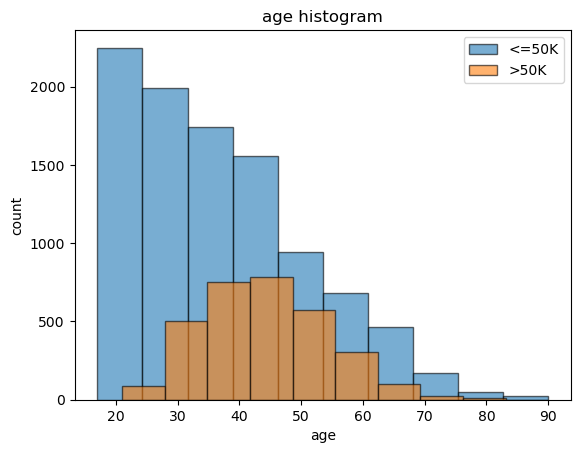

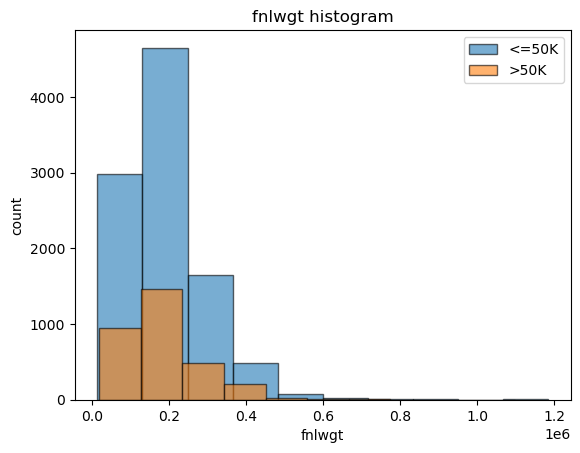

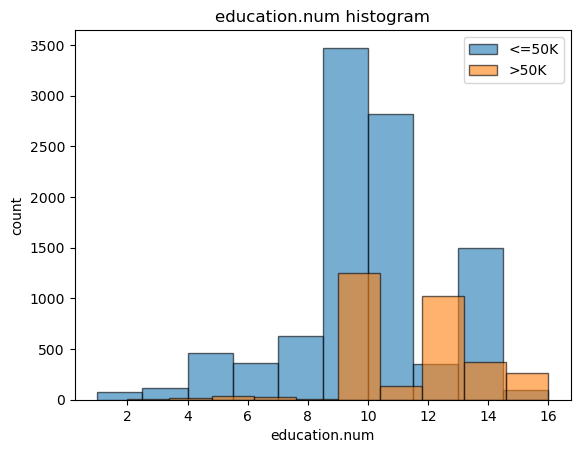

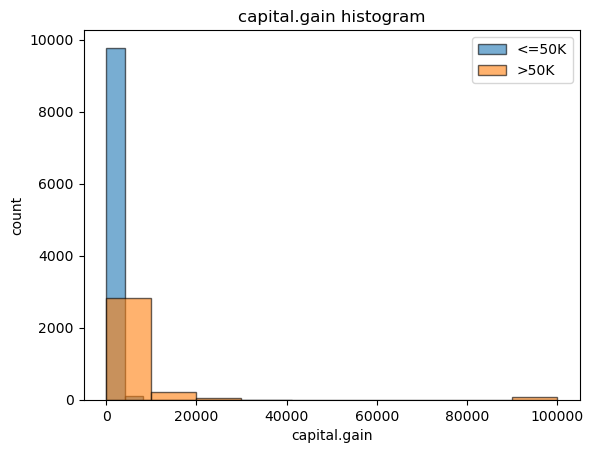

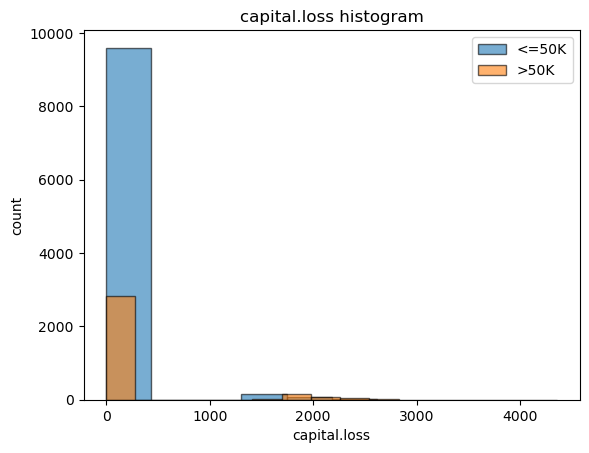

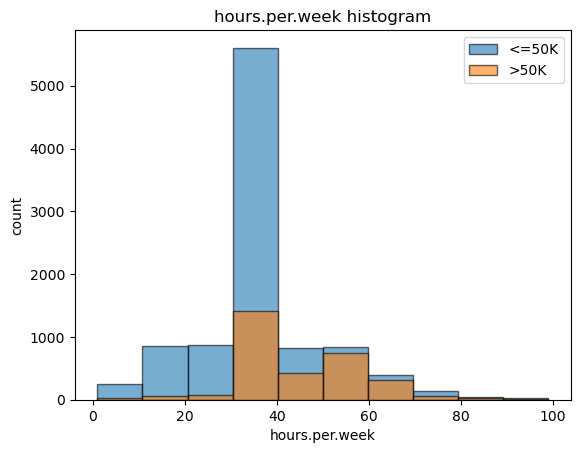

In [12]:
for column in numeric_cols:
    train_df.groupby('income')[column].plot.hist(alpha=0.6, edgecolor="black")
    plt.legend()
    plt.xlabel(column)
    plt.ylabel('count')
    plt.title('%s histogram' % column)
    plt.show()

From the histogram plots, age, capital.gain, capital.loss, and education.num, hours.for.week seem relevant as the data in these plots appears to have a different spread depending on income. The distributions for fnlwgt based on income seem similar (they just have different scaling), so these are likely less useful for classification.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.3 Identify transformations to apply

_Points: 13_

Before passing this data to a machine learning model, we need to apply some transformations on different features. Below we are providing possible transformations which can be applied on each column in `census_df`.  

**Your tasks:**
1. Write your justification or explanation for each row in the explanation column. An example explanation is given for the age column. 

> Note: This question is a bit open-ended. If you do not agree with the provided transformation, feel free to argue your case in the explanation. That said, in this assignment, go with the transformations provided below. 

<div class="alert alert-warning">

Solution_2.3
    
</div>

| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| age | scaling |  A numeric feature with no missing values. Good idea to apply scaling, as the range of values (17 to 90) is quite different compared to other numeric features.|
| workclass | imputation, one-hot encoding | A categorical feature with missing values. Good idea to estimate the values. After missing values are fixed, one-hot encoding should be used since workclass has a set number of discrete categories. It would not make sense to use ordinal encoding because there is no inherent ordering or relationship for the "distance" between two given values in this column.|
| fnlwgt | drop | This value is the number of people the census believes the entry represents. Since this value is not related to classification/ features of the entry itself, it doesn't make sense to use for classification purposes. Further, more than 50% of the values in this column are unique, so it is not particularly useful for classification.|
| education | ordinal encoding | A categorical feature with no missing values. Good idea to use ordinal encoding since there is an inherent ordering/closeness of different education levels. For example, HS-grad and Some-college are closer than 7th-8th and Masters, and this "ordering" can be captured using ordinal encoding. |
| education.num | drop | Drop this since we are going to use ordinal encoding on the education column, which will represent the same kind of data.|
| marital.status | one-hot encoding  | A categorical feature with no missing values. Good idea to use one-hot encoding because there is no inherent ordering or relationship for the "distance" between two given values in this column.|
| occupation | imputation, one-hot encoding  | A categorical feature with missing values. Good idea to estimate the values. After missing values are fixed, one-hot encoding should be used since occupation has a set number of discrete categories. It would not make sense to use ordinal encoding because there is no inherent ordering or relationship for the "distance" between two given values in this column.|
| relationship | one-hot encoding  | A categorical feature with no missing values. Good idea to use one-hot encoding because there is no inherent ordering or relationship for the "distance" between two given values in this column. |
| race | drop  | Race is not inherently linked to income and keeping it in our model could introduce ethically questionable biases into our predictions. Income discrepencies that are correlated with race will can be captured using other features.|
| sex | one-hot encoding with "binary=True" | A categorical feature with no missing values. Good idea to use one-hot encoding because there is no inherent ordering or relationship for the "distance" between two given values in this column. Since there are only 2 possible options in this column, it is a good idea to use "binary=True." |
| capital.gain | scaling | A numeric feature with no missing values. Good idea to apply scaling, as the range of values (0 to 99999) is quite different compared to other numeric features. | 
| capital.loss | scaling | A numeric feature with no missing values. Good idea to apply scaling, as the range of values (0 to 4356) is quite different compared to other numeric features.  |
| hours.per.week | scaling | A numeric feature with no missing values. Good idea to apply scaling, as the range of values (1 to 99) is quite different compared to other numeric features.  |
| native.country | imputation, one-hot encoding | A categorical feature with missing values. Good idea to estimate the values. After missing values are fixed, one-hot encoding should be used since native.country has a set number of discrete categories. It would not make sense to use ordinal encoding because there is no inherent ordering or relationship for the "distance" between two given values in this column.| 


<!-- END QUESTION -->

<br><br>

### 2.4 Identify feature types 

_Points: 5_

**Your tasks:**
1. Based on the types of transformations you want to apply on the features, identify different feature types and store them in the variables below as lists.  

<div class="alert alert-warning">
    
Solution_2.4
    
</div>

In [13]:
# Fill in the lists below.
numeric_features = ["age", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = ["workclass", "marital.status", "occupation", "relationship", "native.country"]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["fnlwgt", "education.num", "race"]
target = "income"


<br><br><br><br>

## Exercise 3: Baseline models 

### 3.1 Separating feature vectors and targets  

_Points: 2_

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df` and `test_df`. 

<div class="alert alert-warning">
    
Solution_3.1
    
</div>

In [14]:
X_train = train_df.drop(columns=target)
y_train = train_df[target]
X_test = test_df.drop(columns=target)
y_test = test_df[target]


<br><br>

### 3.2 Dummy classifier

_Points: 2_

**Your tasks:**

1. Carry out 5-fold cross-validation using `scikit-learn`'s `cross_validate` function with `return_train_scores=True` and store the results as a dataframe named `dummy_df` where each row corresponds to the results from a cross-validation fold. 

<div class="alert alert-warning">
    
Solution_3.2
    
</div>

In [15]:
#adapted from lecture 5

dummy = DummyClassifier(strategy="most_frequent")
dummy_df = pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True))
dummy_df



,fit_time,score_time,test_score,train_score
0,0.004999,0.003001,0.758157,0.758230
1,0.002995,0.002999,0.758157,0.758230
2,0.003999,0.001999,0.758157,0.758230
3,0.003002,0.003000,0.758157,0.758230
4,0.002996,0.003000,0.758449,0.758157


<br><br>

<!-- BEGIN QUESTION -->

### 3.3 Discussion

_Points: 2_

**Your tasks:**

1. Hopefully, you were able to run cross-validation with dummy classifier successfully in the question above. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not? 

<div class="alert alert-warning">
    
Solution_3.3
    
</div>

It will not work with the current data. At this point, we haven't performed pre-processing to apply various transformations to the data. First, we must perform imputation, scaling, and ordinal/ one-hot encoding. Only after that will training an SVC model work.

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 4: Preprocessing
<hr>

In this dataset, we have different types of features: numeric features, an ordinal feature, categorical features, and a binary feature. We want to apply different transformations on different columns and therefore we need a column transformer. In this exercise, first, we'll define different transformations on different types of features and then will create a `scikit-learn`'s `ColumnTransformer`. For example, the code below creates a `numeric_transformer` for numeric features. 

In [16]:
numeric_transformer = StandardScaler()

In the exercises below, you'll create transformers for other types of features. 

<br><br>

### 4.1 Preprocessing ordinal features

_Points: 5_

**Your tasks:**

1. Create a transformer called `ordinal_transformer` for our ordinal features. 

<div class="alert alert-warning">
    
Solution_4.1
    
</div>

In [17]:
ordinal_transformer = OrdinalEncoder( categories=[["Preschool",
                                                 "1st-4th",
                                                 "5th-6th",
                                                 "7th-8th",
                                                 "9th",
                                                 "10th",
                                                 "11th",
                                                 "12th",
                                                 "HS-grad",
                                                 "Prof-school",
                                                 "Assoc-voc",
                                                 "Assoc-acdm",
                                                 "Some-college",
                                                 "Bachelors",
                                                 "Masters",
                                                 "Doctorate"]], dtype= int)

ordinal_transformer.fit(X_train[["education"]])

OrdinalEncoder(categories=[['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th',
                            '10th', '11th', '12th', 'HS-grad', 'Prof-school',
                            'Assoc-voc', 'Assoc-acdm', 'Some-college',
                            'Bachelors', 'Masters', 'Doctorate']],
               dtype=<class 'int'>)

<br><br>

### 4.2 Preprocessing binary features

_Points: 2_

**Your tasks:**

1. Create a transformer called `binary_transformer` for our binary features.

> _Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

<div class="alert alert-warning">
    
Solution_4.2
    
</div>

In [18]:
binary_transformer = OneHotEncoder(drop="if_binary", dtype=int)
binary_transformer.fit(X_train[["sex"]])

OneHotEncoder(drop='if_binary', dtype=<class 'int'>)

<br><br>

### 4.3 Preprocessing categorical features

_Points: 4_

In Exercise 2.3, we saw that there are 3 categorical features with missing values. So first we need to impute the missing values and then encode these features with one-hot encoding. For the purpose of this assignment, let's just have imputation as the first step for all categorical features even when they do not have missing values. This should be OK because if a feature doesn't have any missing value,  imputation won't be applied. 

If we want to apply more than one transformation on a set of features, we need to create a [`scikit-learn` `Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). For example, for categorical features we can create a `scikit-learn` `Pipeline` with first step as imputation and the second step as one-hot encoding. 

**Your tasks:**

1. Create a `sklearn` `Pipeline` using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) called `categorical_transformer` for our categorical features with two steps: `SimpleImputer` for imputation with `strategy="constant"` and `fill_value="missing"` and `OneHotEncoder` with `handle_unknown="ignore"` and `sparse=False` for one-hot encoding. 

<div class="alert alert-warning">
    
Solution_4.3
    
</div>

In [19]:
categorical_transformer = make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"),
                                        OneHotEncoder(handle_unknown="ignore", sparse=False))

<br><br>

### 4.4 Creating a column transformer. 

_Points: 7_

**Your tasks:**
1. Create a `sklearn` `ColumnTransformer` named `preprocessor` using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) with the transformers defined in the previous exercises. Use the sequence below in the column transformer and add a "drop" step for the `drop_features` in the end.  
    - `numeric_transformer`
    - `ordinal_transformer`
    - `binary_transformer`
    - `categorical_transformer`
2. Transform the data by calling `fit_transform` on the training set and save it as a dataframe in a variable called `transformed_df`. How many new columns have been created in the preprocessed data in comparison to the original `X_train`? Store the difference between the number of columns in `transformed_df` and `X_train` in a variable called `n_new_cols`. 

<div class="alert alert-warning">
    
Solution_4.4
    
</div>

In [20]:
#adapted from lecture 6

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features)
)

In [32]:
transformed_df = preprocessor.fit_transform(X_train)
n_new_cols = len(transformed_df[0]) - len(X_train.columns)

print("number of new columns: ", n_new_cols)

number of new columns:  70


<br><br><br><br>

## Exercise 5: Building models 

Now that we have preprocessed features, we are ready to build models. Below, I'm providing the function we used in class which returns mean cross-validation score along with standard deviation for a given model. Use it to keep track of your results. 

In [22]:
results_dict = {}  # dictionary to store all the results

In [23]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

Below I'm showing an example where I call `mean_std_cross_val_scores` with `DummyClassifier`. The function calls `cross_validate` with the passed arguments and returns a series with mean cross-validation results and std of cross-validation. When you train new models, you can just add the results of these models in `results_dict`, which can be easily converted to a dataframe so that you can have a table with all your results. 

In [24]:
# Baseline model

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(random_state = 42)
pipe = make_pipeline(preprocessor, dummy)
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.027 (+/- 0.001),0.010 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)


<br><br>

<!-- BEGIN QUESTION -->

### 5.1 Trying different classifiers

_Points: 10_

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: `preprocessor` from 4.4 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline and get the mean cross-validation scores with std by calling the `mean_std_cross_val_scores` function above. 
    - Store the results in a dataframe called `income_pred_results_df` with the model names in the `models` dictionary below as the index and each row representing results returned by `mean_std_cross_val_scores` function above. In other words, `income_pred_results_df` should look similar to the `results_df` dataframe above with more rows for the models below. 
    
> This might take a while to run. Be patient! 

In [25]:
models = {
    "decision tree": DecisionTreeClassifier(random_state=42),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=42),
}

<div class="alert alert-warning">
    
Solution_5.1
    
</div>

In [26]:
pipelineDecTree = make_pipeline(preprocessor, models["decision tree"])
pipelineKNN = make_pipeline(preprocessor, models["kNN"])
pipelineRBF = make_pipeline(preprocessor, models["RBF SVM"])

results_dict["decision tree"] = mean_std_cross_val_scores(pipelineDecTree, X_train, y_train, cv=5, return_train_score=True)
results_dict["kNN"] = mean_std_cross_val_scores(pipelineKNN, X_train, y_train, cv=5, return_train_score=True)
results_dict["RBF SVM"] = mean_std_cross_val_scores(pipelineRBF, X_train, y_train, cv=5, return_train_score=True)

income_pred_results_df = pd.DataFrame(results_dict).T

income_pred_results_df

,fit_time,score_time,test_score,train_score
dummy,0.027 (+/- 0.001),0.010 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
decision tree,0.078 (+/- 0.008),0.011 (+/- 0.002),0.816 (+/- 0.009),0.987 (+/- 0.001)
kNN,0.030 (+/- 0.001),0.177 (+/- 0.036),0.836 (+/- 0.008),0.883 (+/- 0.002)
RBF SVM,2.568 (+/- 0.797),0.946 (+/- 0.285),0.852 (+/- 0.005),0.855 (+/- 0.002)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 5.2 Discussion 

_Points: 5_

**Your tasks:**

1. Examine the train and validation accuracies and `fit` and `score` times for all the models in the results above. How do the validation accuracies compare to the `DummyClassifier` model? Which model has the best validation accuracy? Which model is the fastest one? Which model is overfitting the most and the least?  


<div class="alert alert-warning">
    
Solution_5.2
    
</div>

The validation accuracies are higher for all models compared to the dummy classifier model. 

RBF SVM has the best validation accuracy. 

The kNN model has the fastest fit time, while the decision tree model has the fastest score time.

The decisions tree model has the largest difference between the test and train scores, inidicating that it is the model that is overfitting the most. RBF SVM has the smallest difference between the test and train score, so it is the model with the least overfitting.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 5.3 Hyperparameter optimization

_Points: 10_

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice, you'll carry out hyperparameter optimization for all different hyperparameters of the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter, namely `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` below: 
    - Create a pipeline object with two steps: preprocessor from 4.4 and `SVC` classifier with the `C` value.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. 
2. Which hyperparameter value seems to be performing the best? Store it in a variable called `best_C`. (Since this question is not autograded, please store the value directly as a number, something like `best_C = 0.001`, if `C = 0.001` is giving you the best CV score.) Is it different than the default value for the hyperparameter used by `scikit-learn`? 

> Note: Running this will take a while. Please be patient. 

In [27]:
param_grid = {"C": np.logspace(-1, 2, 4)}
param_grid

{'C': array([  0.1,   1. ,  10. , 100. ])}

<div class="alert alert-warning">
    
Solution_5.3
    
</div>

In [28]:
for C in param_grid["C"] :
    pipe = make_pipeline(preprocessor, SVC(C=C))
    res = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True)
    results_dict["SVC (C = %.1f)" % C] = res

pd.DataFrame(results_dict)


,dummy,decision tree,kNN,RBF SVM,SVC (C = 0.1),SVC (C = 1.0),SVC (C = 10.0),SVC (C = 100.0)
fit_time,0.027 (+/- 0.001),0.078 (+/- 0.008),0.030 (+/- 0.001),2.568 (+/- 0.797),3.191 (+/- 0.833),2.133 (+/- 1.005),2.030 (+/- 0.701),2.830 (+/- 0.432)
score_time,0.010 (+/- 0.000),0.011 (+/- 0.002),0.177 (+/- 0.036),0.946 (+/- 0.285),1.252 (+/- 0.335),0.938 (+/- 0.325),0.828 (+/- 0.277),0.715 (+/- 0.177)
test_score,0.758 (+/- 0.000),0.816 (+/- 0.009),0.836 (+/- 0.008),0.852 (+/- 0.005),0.838 (+/- 0.006),0.852 (+/- 0.005),0.858 (+/- 0.005),0.860 (+/- 0.006)
train_score,0.758 (+/- 0.000),0.987 (+/- 0.001),0.883 (+/- 0.002),0.855 (+/- 0.002),0.838 (+/- 0.002),0.855 (+/- 0.002),0.862 (+/- 0.002),0.871 (+/- 0.002)


Hyperparameter value C=100 seems to be performing the best. It is different from the value provided when using scikit-learn's default parameter of 1.0.

In [29]:
best_C = 100.0
print("Best C-value: ", best_C)


Best C-value:  100.0


<!-- END QUESTION -->

<br><br><br><br>

## Exercise 6: Evaluating on the test set 
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise, you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 6.1 Scoring on the unseen test set 

_Points: 4_

**Your tasks:**

1. Create a pipeline named `final_pipeline` with the preprocessor from 4.4 as the first step and the best performing SVC model from 5.4 as the second step. 
2. Train the pipeline on the entire training set `X_train` and `y_train`. 
3. Score the pipeline on `X_test` and `y_test` and store the score in a variable called `test_score`.  

<div class="alert alert-warning">
    
Solution_6.1
    
</div>

In [30]:
final_pipeline = make_pipeline(preprocessor, SVC(C=best_C))
final_pipeline.fit(X_train, y_train)
test_score = final_pipeline.score(X_test, y_test)
test_score

0.8497722270563546

<br><br><br><br>

## Exercise 7: Short answer questions

<!-- BEGIN QUESTION -->

### 7.1 kNNs toy example

_Points: 3_

Suppose you want to get predictions using the $k$-nearest neighbour algorithm on the toy dataset below. 

$$ X = \begin{bmatrix}5 & 2\\4 & -2\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}0\\0\\1\\1\\1\\2\end{bmatrix}.$$

Suppose you are given a new data point $x=\begin{bmatrix} 0\\0\end{bmatrix}$.  

1. What would the model predict when $k=1$?
2. What would the model predict when $k=3$?
3. What would the model predict when $k=3$ if we were doing regression rather than classification? 

1. 1 --- [0 0] is closest to [2 2], which has a y = 1.
2. 0 ---             The 3 closest neighbors are [2 2], [4 -2], [5 2]. Two of three have y = 0.
3. 0.33 --- Taking the average of the 3 closest neighbors gives 0.33

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 7.2 Preprocessing

_Points: 8_

1. What is the problem with calling `fit_transform` on your test data with `StandardScaler`?
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. What are two advantages of using sklearn Pipelines? 
4. When is it appropriate to use sklearn `ColumnTransformer`? 

1. We cannot fit StandardScaler on the test data because this would be breaking the Golden Rule. The test data must not be used for training purposes.
2. We use test data to validate our model and see how well it performs. If we violated the Golden Rule and used test data for training our model, we would actually get a slightly better classifier since we are training it using more data. However, we wouldn't know how well our model generalizes to new, unseen data. This would make it difficult to evaluate the efficacy of our model.
3. Pipelines allow us to easily define workflows for transforming and manipulating the data in an organized way. They also allow us to apply fit_transform on the train data, while applying only the transform function on the validation portion in each fold, eliminating any possible "data leakage" between the two portions.
4. ColumnTransformer is useful when we want to apply different transformations on different columns. This is neccessary when the features have different types (binary, ordinal, categorical, etc.) as is most likely with real-world datasets.

<!-- END QUESTION -->

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using [PrairieLearn](https://ca.prairielearn.com/pl/course_instance/6697).

Congratulations on finishing the homework! This was a tricky one but I hope you are feeling good after working on it. You are now ready to build a simple supervised machine learning pipeline on real-world datasets! Well done :clap:! 

![](img/eva-well-done.png)

